# Кластеризация
__Суммарное количество баллов: 10__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[ITMO][ML][MS][HW02] <ФИО>`, где вместо `<ФИО>` указаны фамилия и имя__

В этом домашнем задании предлагается реализовать три различных метода кластеризации, понять, в каких случаях стоит применять те или иные методы, а так же применить один из алгоритмов к задаче уменьшения цветности изображения.

In [1]:
from sklearn.neighbors import KDTree
from sklearn.datasets import make_blobs, make_moons, make_swiss_roll
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import cv2
from collections import deque
from typing import NoReturn

In [2]:
def visualize_clasters(X, labels):
    unique_labels = np.unique(labels)
    unique_colors = np.random.random((len(unique_labels), 3))
    colors = [unique_colors[l] for l in labels]
    plt.figure(figsize=(9, 9))
    plt.scatter(X[:, 0], X[:, 1], c=colors)
    plt.show()

def clusters_statistics(flatten_image, cluster_colors, cluster_labels):
    fig, axes = plt.subplots(3, 2, figsize=(12, 16))
    for remove_color in range(3):
        axes_pair = axes[remove_color]
        first_color = 0 if remove_color != 0 else 2
        second_color = 1 if remove_color != 1 else 2
        axes_pair[0].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=flatten_image, marker='.')
        axes_pair[1].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=[cluster_colors[c] for c in cluster_labels], marker='.')
        for a in axes_pair:
            a.set_xlim(0, 1)
            a.set_ylim(0, 1)
    plt.show()

Генерируем два синтетических набора данных для кластеризации. Далее будем тестировать наши алгоритмы на них.

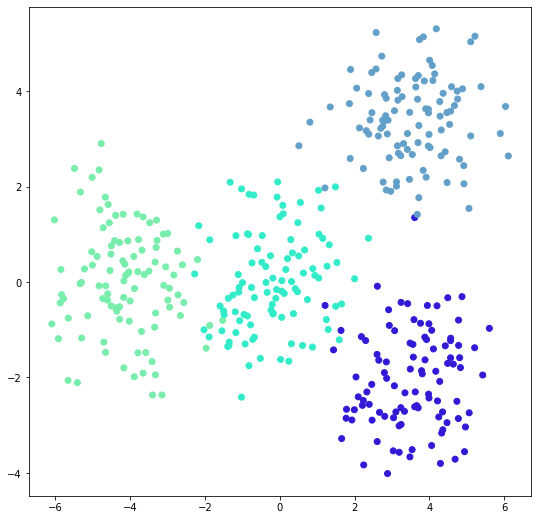

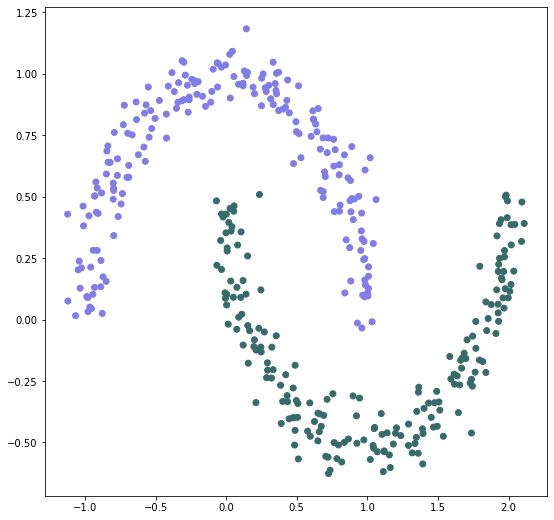

In [3]:
X_1, true_labels = make_blobs(400, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]])
visualize_clasters(X_1, true_labels)
X_2, true_labels = make_moons(400, noise=0.075)
visualize_clasters(X_2, true_labels)

### Задание 1 (3 балла)
Первый метод, который предлагается реализовать - метод K средних.

#### Описание методов
`fit(X, y=None)` ищет и запоминает в `self.centroids` центроиды кластеров для набора данных.
`predict(X)` для каждого элемента из `X` возвращает номер кластера, к которому относится данный элемент.

#### Инициализация кластеров
Есть несколько вариантов инициализации кластеров. Нужно реализовать их все:
1. `random` - центроиды кластеров являются случайными точками
2. `sample` - центроиды кластеров выбираются случайно из набора данных
3. `k-means++` - центроиды кластеров инициализируются при помощи метода K-means++

__Не забудте реинициализировать пустые кластеры!__

In [4]:
class KMeans:
    def __init__(self, n_clusters: int, init: str = "sample", 
                 max_iter: int = 250):
        """
        
        Parameters
        ----------
        n_clusters : int
            Число итоговых кластеров при кластеризации.
        init : str
            Способ инициализации кластеров. Один из трех вариантов:
            1. random --- центроиды кластеров являются случайными точками,
            2. sample --- центроиды кластеров выбираются случайно из  X,
            3. k-means++ --- центроиды кластеров инициализируются 
                при помощи метода K-means++.
        max_iter : int
            Максимальное число итераций для kmeans.
        
        """
        self.n_clusters = n_clusters
        self.init = init
        self.max_iter = max_iter
        self.centroids = None       
        
    def re_init(self, X):
        if self.init == "random":
            return (np.max(X, axis=0) - np.min(X, axis=0)) * np.random.random(1,(np.max(X, axis=0) - np.min(X, axis=0)).shape[0]) + np.min(X, axis=0)
        elif self.init == "sample":
            return X[np.random.randint(0, X.shape[0], 1)]
        elif self.init == "k-means++":
            points = []
            points.append(X[np.random.randint(X.shape[0]), :]) 
            dist = [] 
            for i in range(X.shape[0]): 
              point = X[i, :] 
              d = 0 
              for j in range(len(points)): 
                temp_dist = np.linalg.norm(point - points[j])**2 
                d = max(d, temp_dist) 
              dist.append(d)              
            dist = np.array(dist) 
            next_centroid = X[np.argmax(dist), :] 
            points.append(next_centroid)
            return points
        
    def init_clusters(self, X):
        if self.init == "random":
            self.centroids = (np.max(X, axis=0) - np.min(X, axis=0)) * np.random.random((self.n_clusters,(np.max(X, axis=0) - np.min(X, axis=0)).shape[0])) + np.min(X, axis=0) 
        elif self.init == "sample":
            self.centroids = X[np.random.randint(0, X.shape[0], self.n_clusters)]
        elif self.init == "k-means++":
            points = []
            points.append(X[np.random.randint(X.shape[0]), :])
            for c_id in range(0, self.n_clusters - 1):  
              dist = [] 
              for i in range(X.shape[0]): 
                point = X[i, :] 
                d = 1e5 
                for j in range(len(points)): 
                  temp_dist = np.linalg.norm(point - points[j])**2 
                  d = min(d, temp_dist) 
                dist.append(d)              
              dist = np.array(dist) 
              next_centroid = X[np.argmax(dist), :] 
              points.append(next_centroid)
            self.centroids = np.array(points)
        
    def fit(self, X: np.array, y = None) -> NoReturn:
        """
        Ищет и запоминает в self.centroids центроиды кластеров для X.
        
        Parameters
        ----------
        X : np.array
            Набор данных, который необходимо кластеризовать.
        y : Ignored
            Не используемый параметр, аналогично sklearn
            (в sklearn считается, что все функции fit обязаны принимать 
            параметры X и y, даже если y не используется).
        
        """
        self.init_clusters(X)    
        for k in range(0, self.max_iter):    
          clusters = [[] for i in range(self.n_clusters)]
          #print("Iteration:", k)
          for el in X:
              ind = 0
              d = 1e5
              for clust_id, clust in enumerate(self.centroids):
                  temp_dist = np.linalg.norm(el-clust)
                  if d > temp_dist:
                      d = temp_dist
                      ind = clust_id
              clusters[ind].append(el)
          for clust_id, clust in enumerate(clusters):
            if len(clust) == 0:
              self.centroids[clust_id] = self.re_init(X)
            else:
              self.centroids[clust_id] = np.mean(clust)

    
    def predict(self, X: np.array) -> np.array:
        """
        Для каждого элемента из X возвращает номер кластера, 
        к которому относится данный элемент.
        
        Parameters
        ----------
        X : np.array
            Набор данных, для элементов которого находятся ближайшие кластера.
        
        Return
        ------
        labels : np.array
            Вектор индексов ближайших кластеров 
            (по одному индексу для каждого элемента из X).
        
        """
        return np.argmin([[np.linalg.norm(el-centr) for centr in self.centroids] for el in X], axis=1)

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

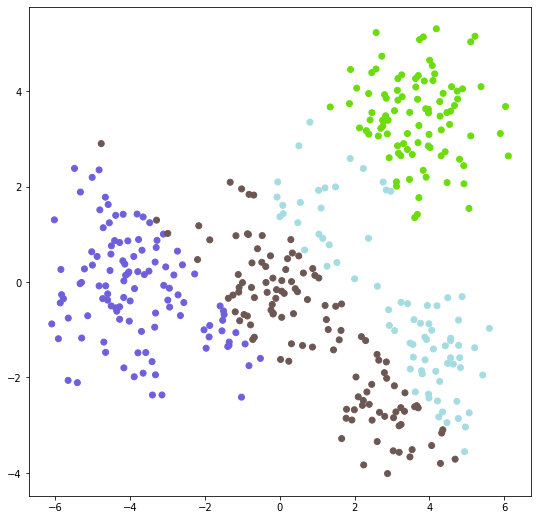

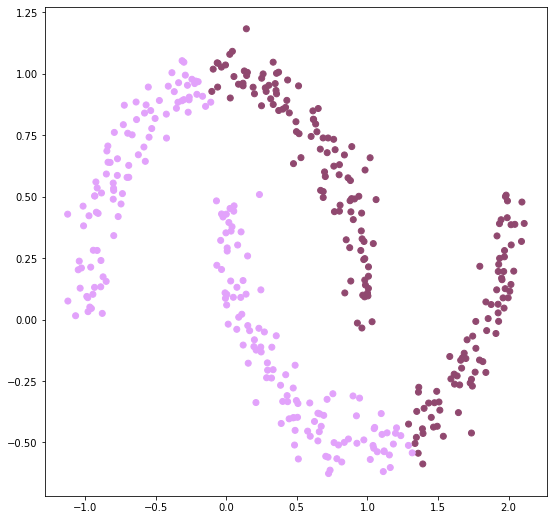

In [5]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(X_1)
labels = kmeans.predict(X_1)
visualize_clasters(X_1, labels)

kmeans = KMeans(n_clusters=2)
kmeans.fit(X_2)
labels = kmeans.predict(X_2)
visualize_clasters(X_2, labels)

### Задание 2 (2 балла)
В отличии от K-means, DBScan не позволяет задать количество кластеров, на которое будут разбиты данные. Руководствуясь геометрической интерпретацией, он позволяет выделять кластеры более сложной формы.

#### Описание методов
`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

#### Возможные метрики
* `euclidean`
* `manhattan`
* `chebyshev`

__Для быстрого поиска соседей используйте `sklearn.neighbors.KDTree`__

In [ ]:
class DBScan:
    def __init__(self, eps: float = 0.5, min_samples: int = 5, 
                 leaf_size: int = 40, metric: str = "euclidean"):
        """
        
        Parameters
        ----------
        eps : float, min_samples : int
            Параметры для определения core samples.
            Core samples --- элементы, у которых в eps-окрестности есть 
            хотя бы min_samples других точек.
        metric : str
            Метрика, используемая для вычисления расстояния между двумя точками.
            Один из трех вариантов:
            1. euclidean 
            2. manhattan
            3. chebyshev
        leaf_size : int
            Минимальный размер листа для KDTree.

        """
        self.eps = eps
        self.min_samples = min_samples
        self.leaf_size = leaf_size
        self.metric = metric    
        
    def fit_predict(self, X: np.array, y = None) -> np.array:
        """
        Кластеризует элементы из X, 
        для каждого возвращает индекс соотв. кластера.
        Parameters
        ----------
        X : np.array
            Набор данных, который необходимо кластеризовать.
        y : Ignored
            Не используемый параметр, аналогично sklearn
            (в sklearn считается, что все функции fit_predict обязаны принимать 
            параметры X и y, даже если y не используется).
        Return
        ------
        labels : np.array
            Вектор индексов кластеров
            (Для каждой точки из X индекс соотв. кластера).

        """
        
        KDtree = KDTree(X, self.leaf_size, self.metric)
        labels = np.array(len(X) * [-1])
        C = 0
        for p, el in enumerate(X):
            if labels[p] != -1:
                continue
            neighbours = KDtree.query_radius(el.reshape((1, len(el))), self.eps)[0].tolist()
            if len(neighbours) < self.min_samples:
                labels[p] = -1
                continue
            labels[p] = C
            C = C + 1 
            for neighbour in neighbours:
                if ((labels[neighbour] != -1) or (neighbour == p)):
                    continue
                labels[neighbour] = C
                neighneighbours = KDtree.query_radius(X[neighbour].reshape((1, len(X[neighbour]))), self.eps)[0]
                if len(neighneighbours) >= self.min_samples:
                    for neighneighbour in neighneighbours:
                        neighbours.append(neighneighbour)
                  
        return labels

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

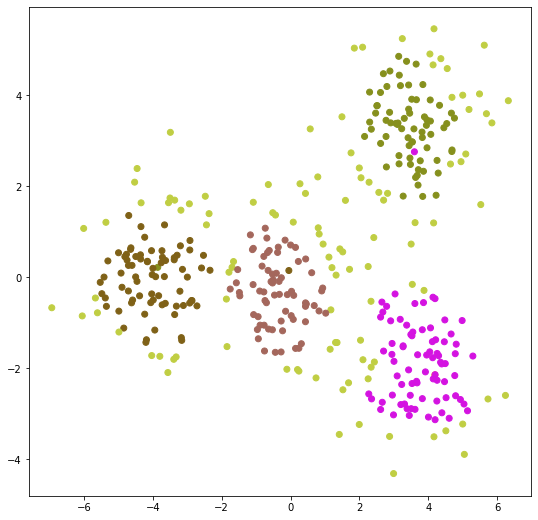

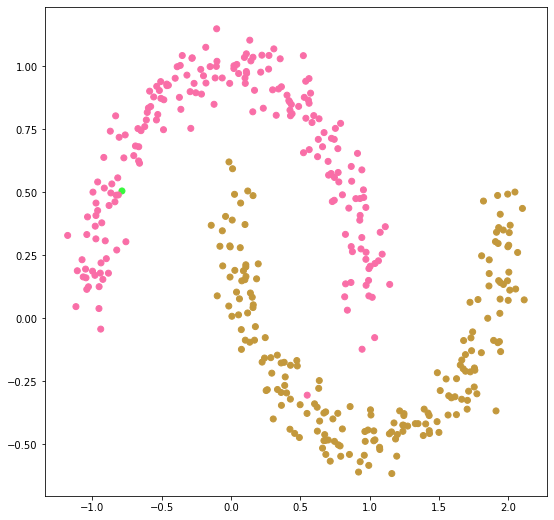

In [ ]:
dbscan = DBScan(eps=0.7, min_samples=15)
labels = dbscan.fit_predict(X_1)
visualize_clasters(X_1, labels)


dbscan = DBScan(eps=0.2)
labels = dbscan.fit_predict(X_2)
visualize_clasters(X_2, labels)

In [ ]:
class AgglomertiveClustering:
    def __init__(self, n_clusters: int = 16, linkage: str = "average"):
        """
        
        Parameters
        ----------
        n_clusters : int
            Количество кластеров, которые необходимо найти (то есть, кластеры 
            итеративно объединяются, пока их не станет n_clusters)
        linkage : str
            Способ для расчета расстояния между кластерами. Один из 3 вариантов:
            1. average --- среднее расстояние между всеми парами точек, 
               где одна принадлежит первому кластеру, а другая - второму.
            2. single --- минимальное из расстояний между всеми парами точек, 
               где одна принадлежит первому кластеру, а другая - второму.
            3. complete --- максимальное из расстояний между всеми парами точек,
               где одна принадлежит первому кластеру, а другая - второму.
        """
        self.n_clusters = n_clusters
        self.linkage = linkage 
    
    def calc_linkage(self, x1, x2):
        dist = []
        for i in range(len(x1)):
            for j in range(len(x2)):
                dist.append(np.absolute(np.linalg.norm(x1[i] - x2[j])))
        dist = np.array(dist)
        if self.linkage == 'average':
            return np.mean(dist)
        elif self.linkage == 'single':
            return np.min(dist)
        elif self.linkage == 'complete':
            return np.max(dist)
    
    def fit_predict(self, X: np.array, y = None) -> np.array:
        """
        Кластеризует элементы из X, 
        для каждого возвращает индекс соотв. кластера.
        Parameters
        ----------
        X : np.array
            Набор данных, который необходимо кластеризовать.
        y : Ignored
            Не используемый параметр, аналогично sklearn
            (в sklearn считается, что все функции fit_predict обязаны принимать 
            параметры X и y, даже если y не используется).
        Return
        ------
        labels : np.array
            Вектор индексов кластеров
            (Для каждой точки из X индекс соотв. кластера).

        """
        clusters = []
        for i in range(len(X)):
            clusters.append([i])
        while len(clusters) > self.n_clusters: 
            dist = np.full((len(clusters), len(clusters)), np.inf)
            for i in range(0, len(clusters)):
                for j in range(i + 1, len(clusters)):
                    dist[i][j] = self.calc_linkage(X[clusters[i]], X[clusters[j]])
            minim_i, minim_j = np.unravel_index(dist.argmin(), dist.shape)
            clusters[minim_i] += clusters[minim_j]
            del clusters[minim_j]
            print("Num of clusters: ", len(clusters))
        labels = np.full(len(X), -1)
        for i in range(len(clusters)):
            for index in clusters[i]:
                labels[index] = i       
        return labels


### Задание 3 (3 балла)
Идея AgglomerativeClustering заключается в том, чтобы итеративно объединять кластеры с наименьшим расстоянием между ними. Данный метод обладает высокой вычислительной сложностью, поэтому применим только для относительно небольших наборов данных.

#### Описание методов
`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

#### Linkage-функции
__Linkage__ - это способ, которым будет рассчитываться расстояние между кластерами. Предлагается реализовать три варианта такой функции:
1. `average` - расстояние рассчитывается как среднее расстояние между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.
2. `single` - расстояние рассчитывается как минимальное из расстояний между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.
2. `complete` - расстояние рассчитывается как максимальное из расстояний между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

Num of clusters:  399
Num of clusters:  398
Num of clusters:  397
Num of clusters:  396
Num of clusters:  395
Num of clusters:  394
Num of clusters:  393
Num of clusters:  392
Num of clusters:  391
Num of clusters:  390
Num of clusters:  389
Num of clusters:  388
Num of clusters:  387
Num of clusters:  386
Num of clusters:  385
Num of clusters:  384
Num of clusters:  383
Num of clusters:  382
Num of clusters:  381
Num of clusters:  380
Num of clusters:  379
Num of clusters:  378
Num of clusters:  377
Num of clusters:  376
Num of clusters:  375
Num of clusters:  374
Num of clusters:  373
Num of clusters:  372
Num of clusters:  371
Num of clusters:  370
Num of clusters:  369
Num of clusters:  368
Num of clusters:  367
Num of clusters:  366
Num of clusters:  365
Num of clusters:  364
Num of clusters:  363
Num of clusters:  362
Num of clusters:  361
Num of clusters:  360
Num of clusters:  359
Num of clusters:  358
Num of clusters:  357
Num of clusters:  356
Num of clusters:  355
Num of clu

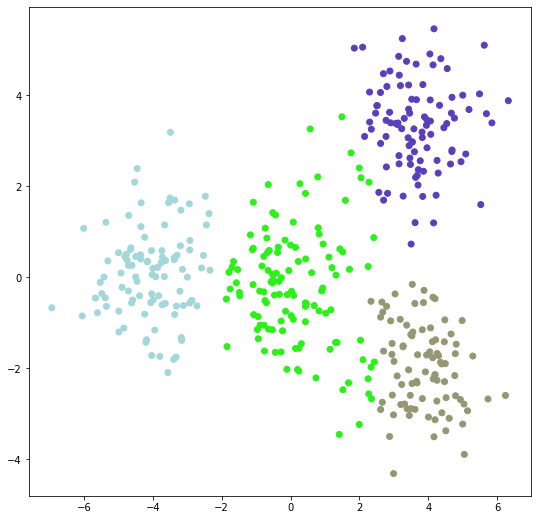

Num of clusters:  399
Num of clusters:  398
Num of clusters:  397
Num of clusters:  396
Num of clusters:  395
Num of clusters:  394
Num of clusters:  393
Num of clusters:  392
Num of clusters:  391
Num of clusters:  390
Num of clusters:  389
Num of clusters:  388
Num of clusters:  387
Num of clusters:  386
Num of clusters:  385
Num of clusters:  384
Num of clusters:  383
Num of clusters:  382
Num of clusters:  381
Num of clusters:  380
Num of clusters:  379
Num of clusters:  378
Num of clusters:  377
Num of clusters:  376
Num of clusters:  375
Num of clusters:  374
Num of clusters:  373
Num of clusters:  372
Num of clusters:  371
Num of clusters:  370
Num of clusters:  369
Num of clusters:  368
Num of clusters:  367
Num of clusters:  366
Num of clusters:  365
Num of clusters:  364
Num of clusters:  363
Num of clusters:  362
Num of clusters:  361
Num of clusters:  360
Num of clusters:  359
Num of clusters:  358
Num of clusters:  357
Num of clusters:  356
Num of clusters:  355
Num of clu

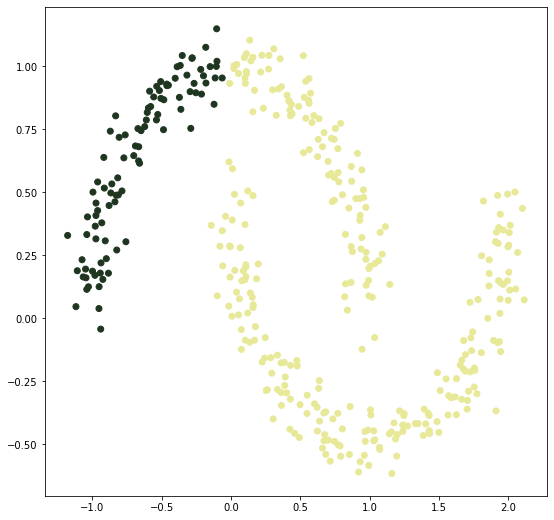

In [ ]:
agg_clustering = AgglomertiveClustering(n_clusters=4, linkage='complete')
labels = agg_clustering.fit_predict(X_1)
visualize_clasters(X_1, labels)

agg_clustering = AgglomertiveClustering(n_clusters=2)
labels = agg_clustering.fit_predict(X_2)
visualize_clasters(X_2, labels)

### Задание 4 (1 балл)
Реализуйте методы считывания и записи изображения при помощи библиотеки OpenCV. 

#### Описание методов
`read_image(path)` читает изображение и возвращает его в виде трехмерного numpy массива размера `(N, M, C)`, где `N` и `M` - размеры изображения, а `C` - количество цветов (3 для обычного изображения)
`save_image(image, path)` сохраняет изображение.

__Учтите, что `cv2.imread` считывает изображение в цветовой схеме BGR. После считывания необходимо перевести его в RGB и нормализовать__

In [6]:
def read_image(path: str) -> np.array:
    """
    Читает изображение.

    Parameters
    ----------
    path : str
        Путь к изображению.
    
    Return
    ------
    image : np.array
        Трехмерный массив размера (N, M, C), 
        где N и M - размеры изображения, 
        а C - количество цветов (3 для обычного изображения).
    """
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) / 255
    return image

def show_image(image: np.array) -> NoReturn:
    """
    Выводит изображение

    Parameters
    ----------
    image : np.array
        Трехмерный массив - нормализованное изображение в цветовой схеме RGB.
    """
    plt.figure(figsize=np.array(image.shape[:-1]) / 50)
    plt.imshow(image)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def save_image(image: np.array, path: str) -> NoReturn:
    """
    Сохраняет изображение.

    Parameters
    ----------
    image : np.array
        Трехмерный массив - нормализованное изображение в цветовой схеме RGB.
    path : str
        Путь для сохранения.
    """
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    cv2.imwrite(path, image)

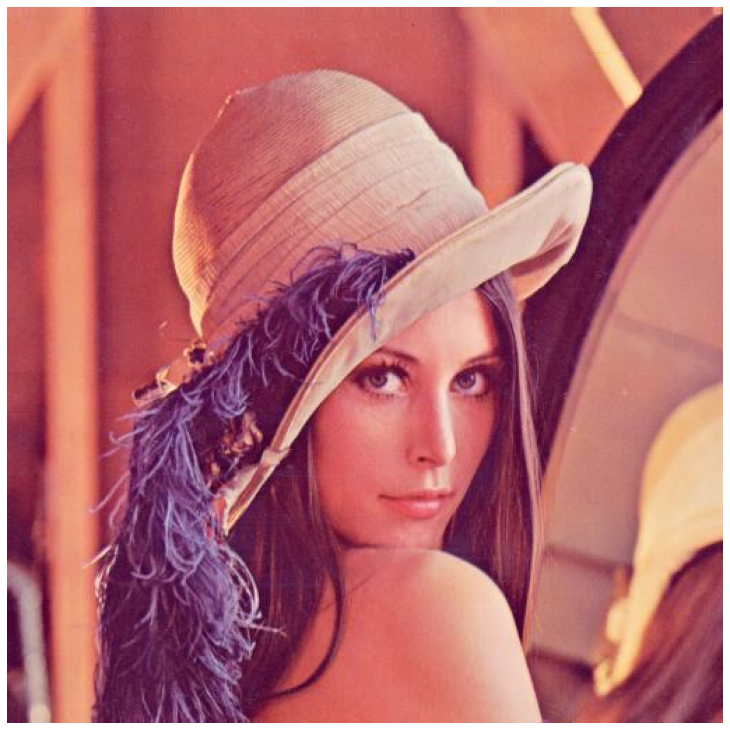

In [8]:
show_image(read_image("./Lena4.bmp"))

### Задание 5 (1 балл)
Реализуйте функцию, которая будет кластеризовать цвета изображения одним из реализованных алгоритмов. Интерфейс этой функции можно менять. Функция должна возвращать новое изображение, в котором цвета заменены на цвета кластеров.

Затем примените ее к цветам изображения.

__Примечание: это задание проще всего выполнить при помощи KMeans__

In [13]:
def clusterize_image(image, num_colors, random=True, max_iter=300):    
    pix = image.reshape((image.shape[0] * image.shape[1], image.shape[2]))
    model = KMeans(n_clusters=num_colors, init='sample', max_iter=max_iter)
    model.fit(pix)
    labels = model.predict(pix)    
    if random:
        cluster_colors = np.random.random((num_colors, 3))
    else:
        colors = [[] for i in range(num_colors)]
        cluster_colors = np.zeros((num_colors, 3))
        for l, p in zip(labels, pix):
            colors[l].append(p)
        for l in labels:
            cluster_colors[l] = sum(colors[l]) / len(colors[l])
    recolored_image = np.asarray(list(map(lambda l: cluster_colors[l], labels)))
    recolored_image = recolored_image.reshape(image.shape)   
    clusters_statistics(image.reshape(-1, 3), cluster_colors, labels) # Very slow (:
    return recolored_image

In [ ]:
image = read_image("./animals.jpg")
result = clusterize_image(image, 10, max_iter=1000, random=False)
show_image(result)
save_image(result, "result.jpg")